In [30]:
pip install matplotlib seaborn scikit-learn shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 12.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 12.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 10.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import requests

url = "http://192.168.0.222:3000/csv/detecting_testing_applied_rules_93e874d3-a01e-4467-ac61-958e5ff22b85.csv"

response = requests.get(url)
with open("network_data.csv", "wb") as file:
    file.write(response.content)

df = pd.read_csv("network_data.csv")


In [4]:
# Check for missing values
print(df.isnull().sum())

# Check data types
print(df.dtypes)


timestamp         0
source_ip         0
destination_ip    0
protocol          0
length            0
http_scan         0
ping_scan         0
nmap_scan         0
unmalicious       0
maybemalicious    0
malicious         0
dtype: int64
timestamp         object
source_ip         object
destination_ip    object
protocol          object
length             int64
http_scan          int64
ping_scan          int64
nmap_scan          int64
unmalicious        int64
maybemalicious     int64
malicious          int64
dtype: object


              length      http_scan  ping_scan      nmap_scan    unmalicious  \
count  147019.000000  147019.000000   147019.0  147019.000000  147019.000000   
mean      117.825852       0.006965        0.0       0.452799       0.006965   
std       278.897565       0.083166        0.0       0.497769       0.083166   
min        56.000000       0.000000        0.0       0.000000       0.000000   
25%        56.000000       0.000000        0.0       0.000000       0.000000   
50%        62.000000       0.000000        0.0       0.000000       0.000000   
75%        62.000000       0.000000        0.0       1.000000       0.000000   
max      1516.000000       1.000000        0.0       1.000000       1.000000   

       maybemalicious      malicious  
count        147019.0  147019.000000  
mean              0.0       0.452799  
std               0.0       0.497769  
min               0.0       0.000000  
25%               0.0       0.000000  
50%               0.0       0.000000  
75%   

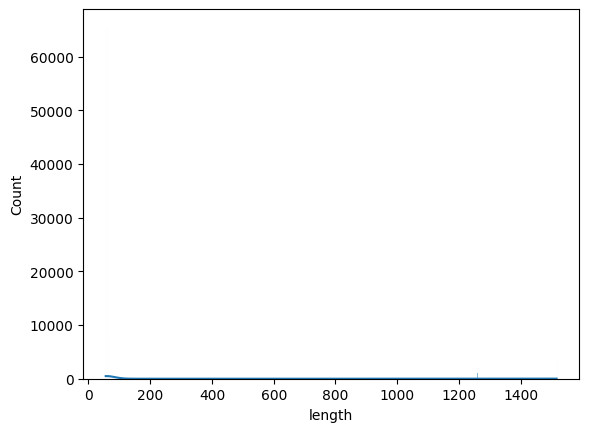

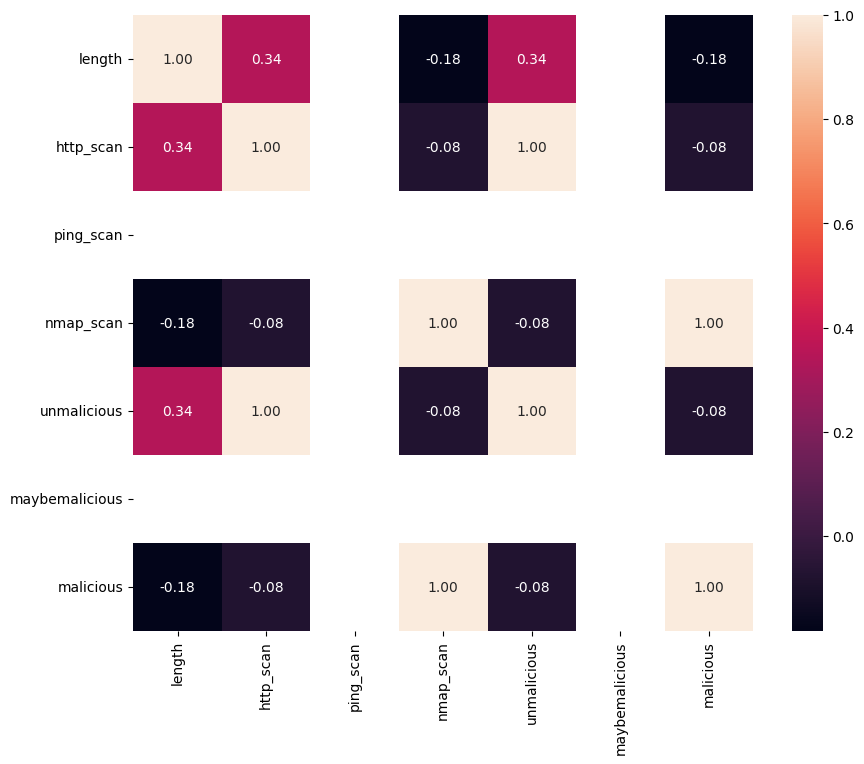

In [11]:
import numpy as np  # Importing NumPy

# Statistical summary
print(df.describe())

# For visualizations, you can use libraries like matplotlib or seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Distribution of 'length'
sns.histplot(df['length'], kde=True)
plt.show()

# Exclude non-numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=[np.number])

# Now, you can safely compute the correlation matrix and plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f")
plt.show()


In [12]:
# Example: Selecting features based on correlation analysis
# This is a simplified approach, you might need more sophisticated methods like Feature Importance from RandomForest

features = df[['length', 'http_scan', 'ping_scan', 'nmap_scan']]  # Example feature set
target = df['malicious']  # Assuming 'malicious' is the target variable


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
model = DecisionTreeClassifier()

# Fit the model
model.fit(X_train, y_train)


DecisionTreeClassifier()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[16064     0]
 [    0 13340]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16064
           1       1.00      1.00      1.00     13340

    accuracy                           1.00     29404
   macro avg       1.00      1.00      1.00     29404
weighted avg       1.00      1.00      1.00     29404



In [19]:
# Feature importance
importance = pd.DataFrame({'feature': features.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
print(importance)


     feature  importance
3  nmap_scan         1.0
0     length         0.0
1  http_scan         0.0
2  ping_scan         0.0


In [20]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


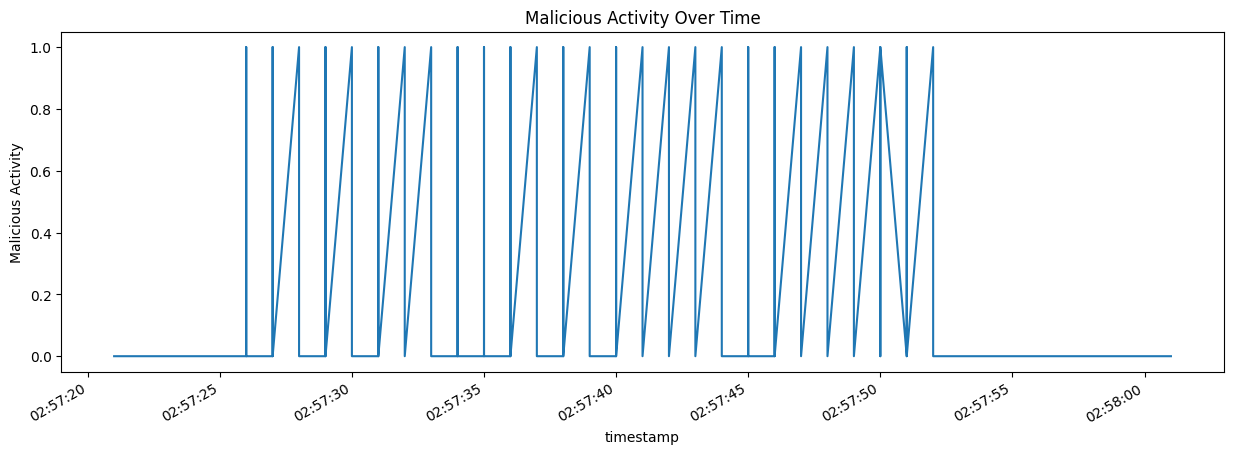

In [21]:
df.set_index('timestamp')['malicious'].plot(figsize=(15, 5))
plt.ylabel('Malicious Activity')
plt.title('Malicious Activity Over Time')
plt.show()


In [22]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek


In [23]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


RandomForestClassifier()

In [24]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_split': [2, 5, 10]})

In [25]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, features, target, cv=5, scoring='roc_auc')
print("ROC-AUC scores:", scores)


ROC-AUC scores: [1. 1. 1. 1. 1.]


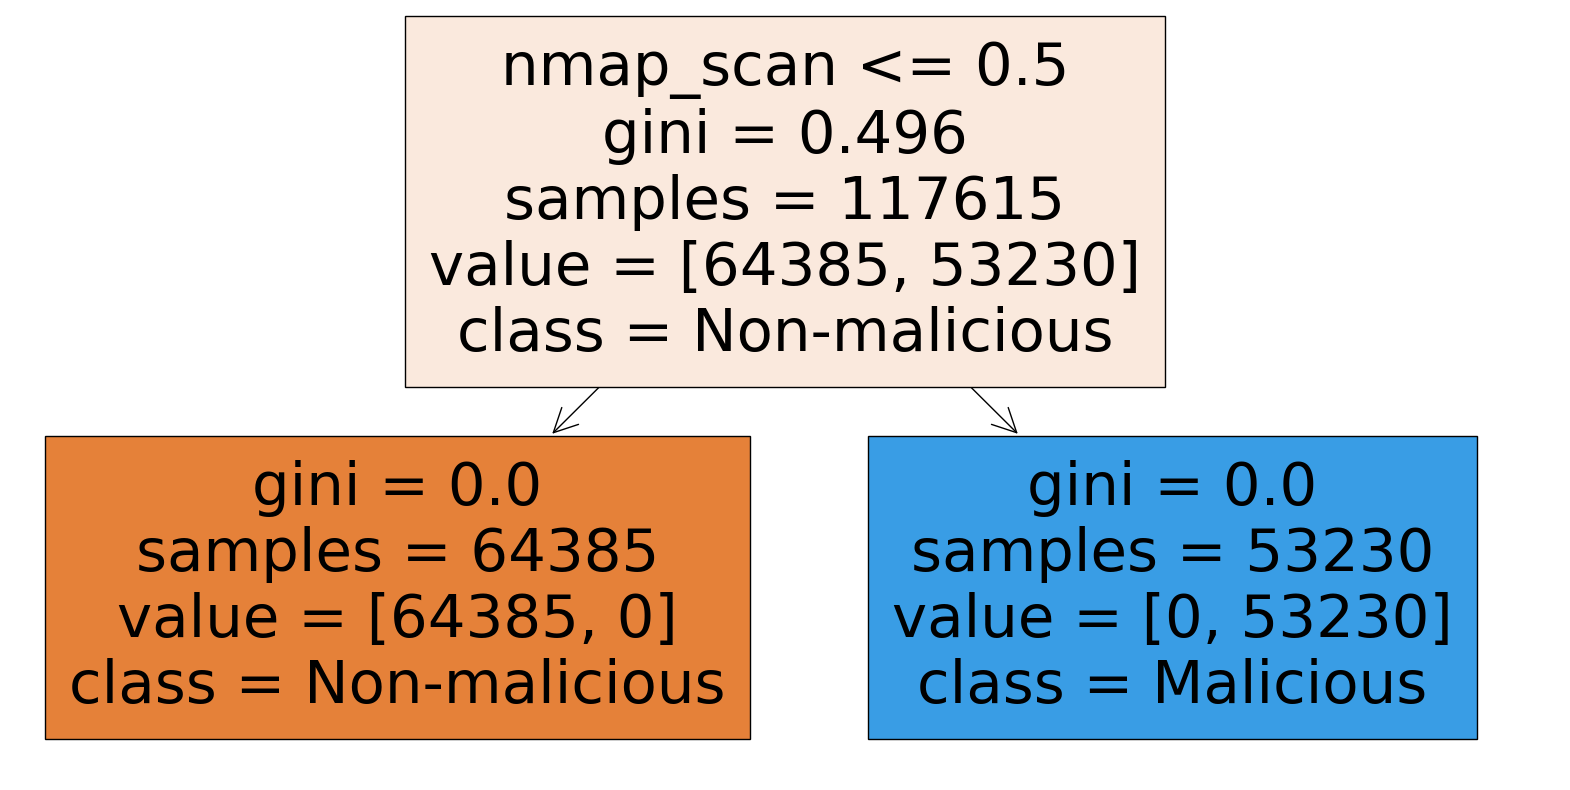

In [26]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=features.columns, class_names=['Non-malicious', 'Malicious'], max_depth=3)
plt.show()


In [27]:
from sklearn.model_selection import cross_val_score
rf_cross_val_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"Random Forest Cross-Validation Scores: {rf_cross_val_scores.mean():.2f} ± {rf_cross_val_scores.std():.2f}")


Random Forest Cross-Validation Scores: 1.00 ± 0.00


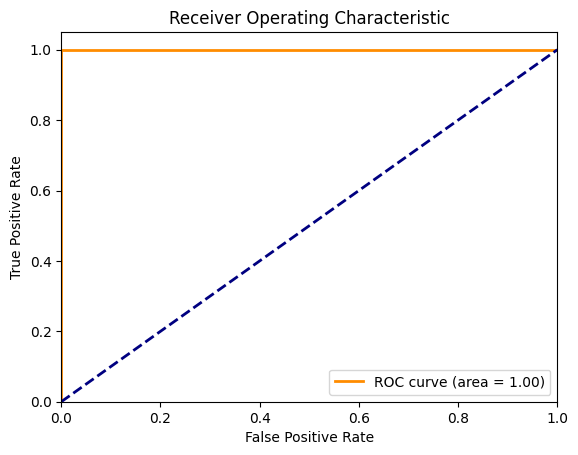

In [28]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


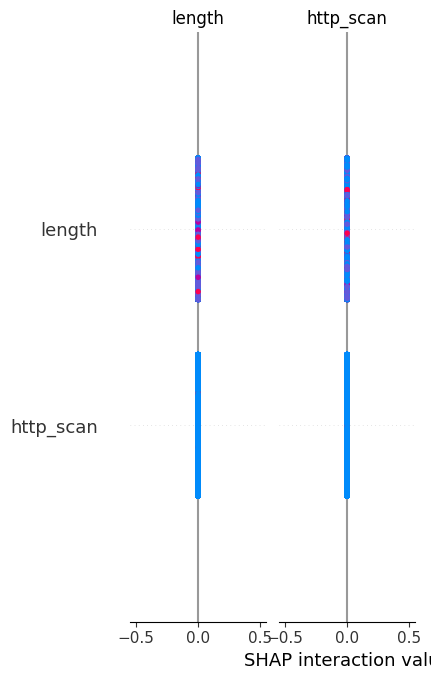

In [31]:
import shap
# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Plot summary plot
shap.summary_plot(shap_values, X_train, feature_names=features.columns)


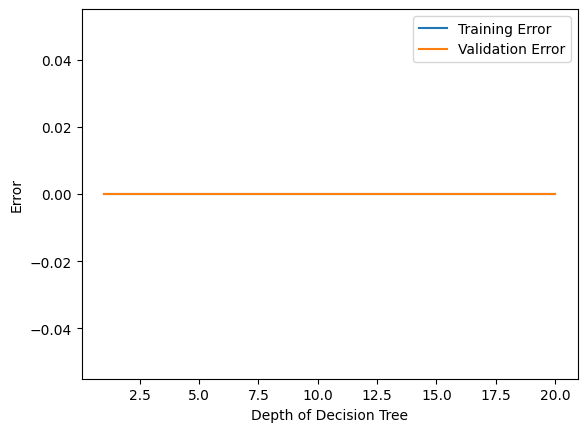

In [32]:
depths = range(1, 21)
training_error = []
validation_error = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X_train, y_train)
    
    training_error.append(1 - model.score(X_train, y_train))
    validation_error.append(1 - model.score(X_test, y_test))

plt.plot(depths, training_error, label='Training Error')
plt.plot(depths, validation_error, label='Validation Error')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Error')
plt.legend()
plt.show()
